Import all necessary packages and functions

In [30]:
from scipy.sparse import load_npz
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

We will be looking into 3 different models:

1. Naive Bayes classification on Bag of Words (BoW) + TF-IDF
2. Naive Bayes classification on word n-grams + TF-IDF
3. Naive Bayes classification on character n-grams + TF-IDF

In [12]:
# Load preprocessed features (sparse)
X_train = load_npz("X_train_sparse.npz")
X_test = load_npz("X_test_sparse.npz")

# Load labels
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [13]:
btf_cols = 20000
wordtf_cols = 1000
chartf_cols = 500

# Split training features
X_btf_train = X_train[:, :btf_cols]
X_word_train = X_train[:, btf_cols:btf_cols + wordtf_cols]
X_char_train = X_train[:, btf_cols + wordtf_cols:]

# Split test features
X_btf_test = X_test[:, :btf_cols]
X_word_test = X_test[:, btf_cols:btf_cols + wordtf_cols]
X_char_test = X_test[:, btf_cols + wordtf_cols:]

In [24]:
def run_naive_bayes(X_train, X_test, y_train, y_test, name=""):
    print(f"\n{name} Naive Bayes Results:")
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    # Confusion Matrix
    conf_mat_ngt = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat_ngt, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: " + name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve and AUC
    fpr_ngt, tpr_ngt, _ = roc_curve(y_test, y_prob)
    auc_ngt = roc_auc_score(y_test, y_prob)

    plt.plot(fpr_ngt, tpr_ngt, label=f"AUC = {auc_ngt:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve: " + name)
    plt.legend()
    plt.show()


BoW + TF-IDF Naive Bayes Results:
Accuracy: 0.9445282120466629
Precision: 0.9609457092819614
Recall: 0.9201744088546034
F1 Score: 0.94011822153688


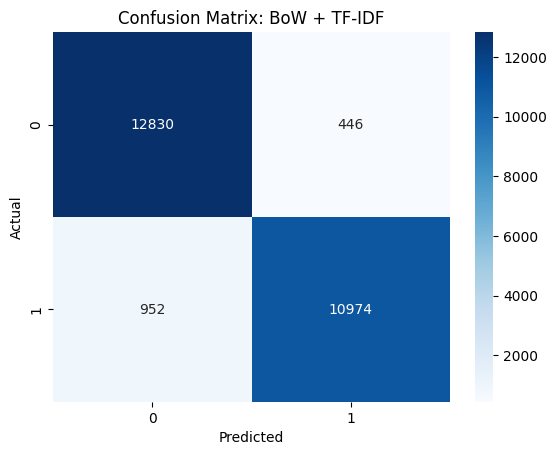

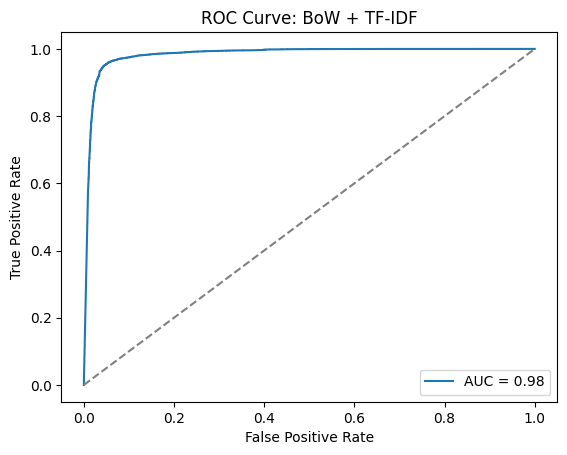


Word n-grams + TF-IDF Naive Bayes Results:
Accuracy: 0.9046901039600032
Precision: 0.9124372076909752
Recall: 0.8833640784839846
F1 Score: 0.8976653033401499


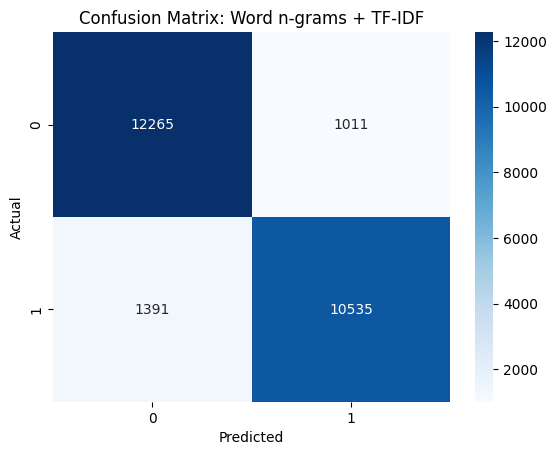

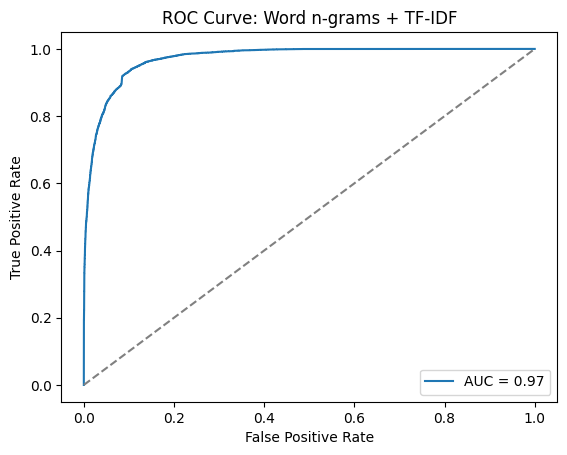


Char n-grams + TF-IDF Naive Bayes Results:
Accuracy: 0.8108880247599397
Precision: 0.8662778800900348
Recall: 0.7099614288110012
F1 Score: 0.78036866359447


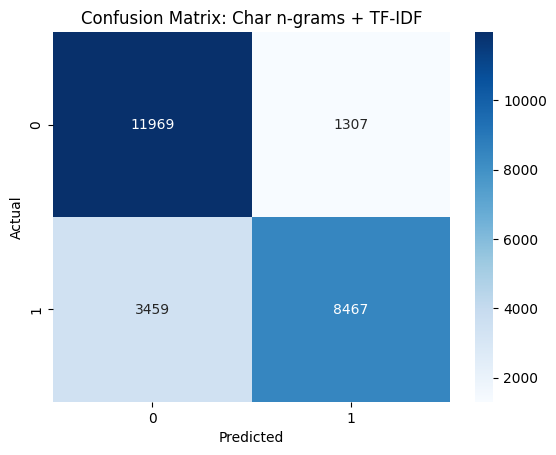

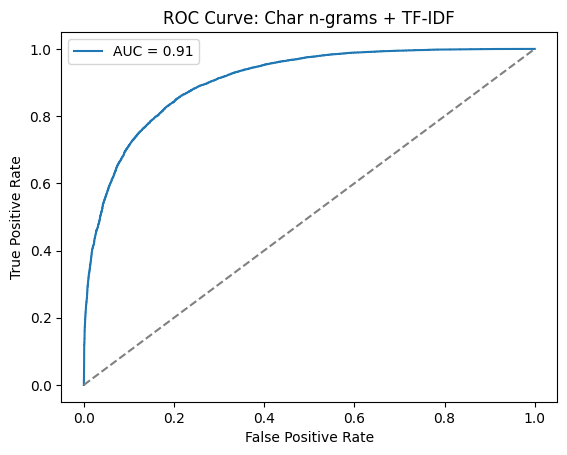


All features combined Naive Bayes Results:
Accuracy: 0.9525037695420998
Precision: 0.9521281078803203
Recall: 0.9472580915646487
F1 Score: 0.9496868563742592


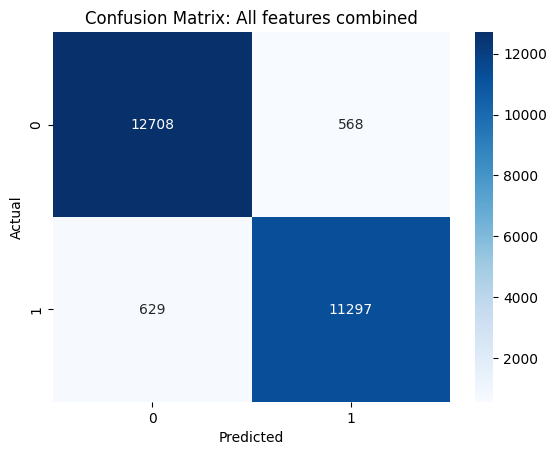

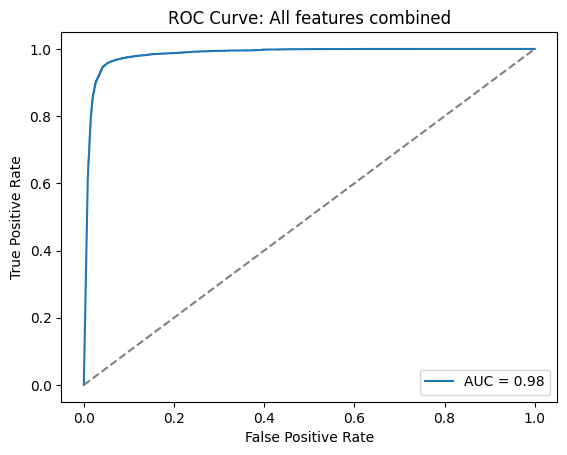

In [26]:
run_naive_bayes(X_btf_train, X_btf_test, y_train, y_test, "BoW + TF-IDF")
run_naive_bayes(X_word_train, X_word_test, y_train, y_test, "Word n-grams + TF-IDF")
run_naive_bayes(X_char_train, X_char_test, y_train, y_test, "Char n-grams + TF-IDF")
run_naive_bayes(X_train, X_test, y_train, y_test, "All features combined")

In [33]:
with open("training_ngrams_countvec.pkl", "rb") as f:
    ngrams_bow = pickle.load(f)
X_ngb = hstack([
    vstack(ngrams_bow['body_countvec'].values),
    vstack(ngrams_bow['body_char_countvec'].values)
])
y_ngb = ngrams_bow['label'].values

with open("training_ngrams_tfidf.pkl", "rb") as f:
    ngrams_tfidf = pickle.load(f)
X_ngt = hstack([
    vstack(ngrams_tfidf['body_tfidf'].values),
    vstack(ngrams_tfidf['body_char_tfidf'].values)
])
y_ngt = ngrams_tfidf['label'].values

with open("engineered_features_bow_tfidf.pkl", "rb") as f:
    bow_tfidf_dict = pickle.load(f)
bow_tfidf_df = pd.DataFrame(bow_tfidf_dict)
sampled = bow_tfidf_df
X_btf = hstack([
    vstack(bow_tfidf_df['X_bow'].values),
    vstack(bow_tfidf_df['X_tfidf'].values)
])
y_btf = bow_tfidf_df['label'].values

X_bow_reduced = vstack([x[:, :500] for x in bow_tfidf_df["X_bow"].iloc[:3000]])
X_tfidf_reduced = vstack([x[:, :500] for x in bow_tfidf_df["X_tfidf"].iloc[:3000]])
X_btf_reduced = hstack([X_bow_reduced, X_tfidf_reduced])

y_btf_sample = bow_tfidf_df["label"].values[:3000]


feature_names_bow = bow_tfidf_dict["bow_vectorizer"].get_feature_names_out()[:500]
feature_names_tfidf = bow_tfidf_dict["tfidf_vectorizer"].get_feature_names_out()[:500]
feature_names = np.concatenate([feature_names_bow, feature_names_tfidf])


model = MultinomialNB()
model.fit(X_btf_reduced, y_btf_sample)


log_probs = model.feature_log_prob_

# Difference = how "spammy" a feature is
feature_diff = log_probs[1] - log_probs[0]

coef_tuples = list(zip(feature_names, feature_diff))

# Sort by importance
coef_tuples.sort(key=lambda x: x[1])
top_n = 20
top_negative = coef_tuples[:top_n]
top_positive = coef_tuples[-top_n:]

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

axs[0].barh([k for k, _ in top_negative], [v for _, v in top_negative])
axs[0].set_title("Top Features Pushing to Class 0 (Ham)")
axs[0].invert_yaxis()

axs[1].barh([k for k, _ in reversed(top_positive)], [v for _, v in reversed(top_positive)])
axs[1].set_title("Top Features Pushing to Class 1 (Spam)")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

	•	Spam-indicative features (right): Terms like "advertisement", "adobe", "adult", and "actual result" are strongly associated with spam content. Many of these reflect marketing language or specific product mentions.
	•	Ham-indicative features (left): Names like "anjam", "anita", and terms like "agenda", "appreciate help", and "america corp" suggest professional or interpersonal communication patterns typical of non-spam emails.